#Pinsipal Component Analysy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from scipy.spatial.transform import Rotation


m = 60
X = np.zeros((m,3))
np.random.seed(42)
angels = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi
X[: , 0], X[:, 1] = np.cos(angels), np.sin(angels) * 0.5
X += 0.28 * np.random.randn(m, 3)
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20 ,np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [ ]:
X2D.shape

(60, 2)

In [ ]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

In [ ]:
pca.explained_variance_ratio_            # her kecirdiyi vektorda hansi ne qeder data var faizle onu gosterir. Birinci kecirdiyi vaktorda 75%, ikincide 15% data var

array([0.7578477 , 0.15186921])

In [ ]:
1 - pca.explained_variance_ratio_.sum()        #ne qeder data itirdiyimizi bilmek ucun 1 -den componentlerde olan data miqdariinin cemini cixiriq

0.09028309326742034

Ne qeder data itirmeye haziriqsa o qeder reduction edirik Dimensionality

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',  as_frame = False, parser = 'auto')
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [ ]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

154

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.9706

In [ ]:
test_reduced = pca.transform(X_test)

In [ ]:
rfc.fit(X_reduced, y_train)

RandomForestClassifier()

In [ ]:
rfc.score(test_reduced, y_test)

0.9503

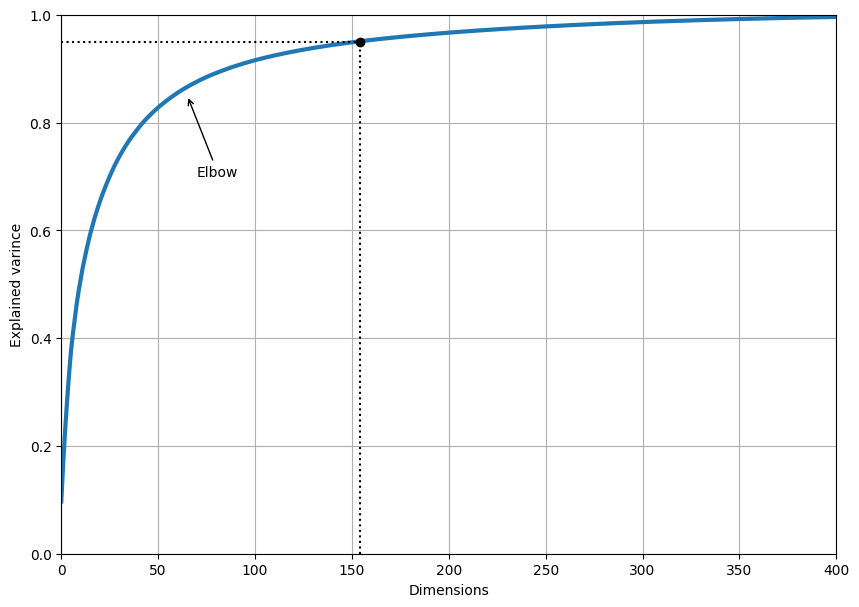

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(cumsum, linewidth = 3)
plt.axis([0, 400, 0, 1])
plt.xlabel('Dimensions')
plt.ylabel("Explained varince")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, 'ko')
plt.annotate("Elbow", xy =(65, 0.85), xytext = (70, 0.7),
             arrowprops = dict(arrowstyle = '->'))
plt.grid(True)
plt.show()

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

pipeline = make_pipeline(PCA(),
                         RandomForestClassifier(random_state = 42))

param_grid = {
    "pca__n_components" : np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50,500)
}

rscv = RandomizedSearchCV(pipeline, param_grid, n_iter = 10, cv = 3)
rscv.fit(X_train[:1_000], y_train[:1_000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 6...
       401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413,
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])})

In [ ]:
rscv.best_params_

{'randomforestclassifier__n_estimators': 179, 'pca__n_components': 47}

In [ ]:
cumsum[58]

0.850187763928468

In [ ]:
rscv.score(X_test, y_test)

0.8577

In [ ]:
print(rscv.best_params_)

{'randomforestclassifier__n_estimators': 179, 'pca__n_components': 47}


In [ ]:
rscv.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=47)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=179, random_state=42))])

In [ ]:
rscv.best_estimator_.score(X_train, y_train), rscv.best_estimator_.score(X_test, y_test)

(1.0, 0.9571)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

sgd_pipeline = make_pipeline(PCA(random_state = 42),
                             SGDClassifier(random_state=42))

sgd_param_grid = {
    "pca__n_components" : np.arange(10, 80)
}
sgd_gscv = GridSearchCV(sgd_pipeline, sgd_param_grid, cv = 3)
sgd_gscv.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(random_state=42))]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [ ]:
sgd_gscv.best_params_

{'pca__n_components': 79}

In [ ]:
best_model = sgd_gscv.best_estimator_

In [ ]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=79, random_state=42)),
                ('sgdclassifier', SGDClassifier(random_state=42))])

In [ ]:
best_model.score(X_train, y_train), best_model.score(X_test, y_test)

(0.8830833333333333, 0.8886)

Incremental PCA --> eger PCA edirikse butun data RAM a yigilir. Bele oldugu halda Inceremental PCA kimi yollardan istifade olunur. O melumatlari hissi hisse emal edir.

#PCA for comperension

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)

  X_reduced = inc_pca.transform(X_train)

#LLM

projection / manifold - 2 approach

In [ ]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples = 1000, noise = 0.2, random_state = 42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors = 10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

#Hands - on

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False, parser = 'auto')             #parser ozu duzgun bolsun deye verir
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]